Questo notebook mostra un esempio di un segnale target detrendizzato usando la funzione built in di scipy detrend

In [56]:
import xarray as xr
import pandas as pd
from scipy.signal import detrend

In [53]:
import os 

files = [f for f in os.listdir() if f.endswith('.nc')]
files    

['adda.nc', 'dora.nc', 'ticino.nc']

In [55]:
files[0].split(".")[0]

'adda'

In [57]:
df = xr.open_dataset('dora.nc')
df

<xarray.Dataset>
Dimensions:                   (time: 484, ydim: 389, xdim: 453)
Coordinates:
  * time                      (time) object 2000-02-18 00:00:00 ... 2021-02-1...
  * ydim                      (ydim) float64 5.114e+06 5.114e+06 ... 5.024e+06
  * xdim                      (xdim) float64 5.274e+05 5.276e+05 ... 6.321e+05
Data variables:
    crs                       int8 ...
    _250m_16_days_NDVI        (time, ydim, xdim) float32 ...
    _250m_16_days_VI_Quality  (time, ydim, xdim) float64 ...
Attributes:
    title:        MOD13Q1.006 for aid0001
    Conventions:  CF-1.6
    institution:  Land Processes Distributed Active Archive Center (LP DAAC)
    source:       AppEEARS v2.70
    references:   See README.md
    history:      See README.md

In [20]:
datetimeindex = df.indexes['time'].to_datetimeindex()

<ipython-input-20-6f822878c597>:1: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = df.indexes['time'].to_datetimeindex()


In [21]:
df = df.to_dataframe()

In [22]:
df = df[~df._250m_16_days_NDVI.isna()].reset_index()
df = df[['time','_250m_16_days_NDVI']]
df #in questo caso il dataframe è il risultato dell'estrazione dell'ndvi sulle coordinate geografiche del raster 

,time,_250m_16_days_NDVI
0,2000-02-18 00:00:00,-0.0243
1,2000-02-18 00:00:00,-0.0289
2,2000-02-18 00:00:00,-0.0277
3,2000-02-18 00:00:00,-0.0354
4,2000-02-18 00:00:00,-0.0248
...,...,...
34009806,2021-02-18 00:00:00,0.3489
34009807,2021-02-18 00:00:00,0.3434
34009808,2021-02-18 00:00:00,0.3644
34009809,2021-02-18 00:00:00,0.3819


In [23]:
df = df.groupby('time').apply(lambda x: x.mean()) # faccio una media del tutto -> per ogni data medio su tutta l'area geografica identficata dai punti del raster

In [24]:
df = df.reset_index()
df['time'] = datetimeindex

In [25]:
df

,time,_250m_16_days_NDVI
0,2000-02-18,0.124917
1,2000-03-05,0.145729
2,2000-03-21,0.160547
3,2000-04-06,0.175506
4,2000-04-22,0.210931
...,...,...
479,2020-12-18,0.116728
480,2021-01-01,0.082768
481,2021-01-17,0.109213
482,2021-02-02,0.138695


In [28]:
df = df.resample('W',on='time').mean().interpolate().reset_index() # dal dataset MODIS i dati sono disponibili ogni 16 settimane -> interpolazione per avere un dato settimanale

In [29]:
df

,time,_250m_16_days_NDVI
0,2000-02-20,0.124917
1,2000-02-27,0.135323
2,2000-03-05,0.145729
3,2000-03-12,0.150668
4,2000-03-19,0.155607
...,...,...
1092,2021-01-24,0.119041
1093,2021-01-31,0.128868
1094,2021-02-07,0.138695
1095,2021-02-14,0.142033


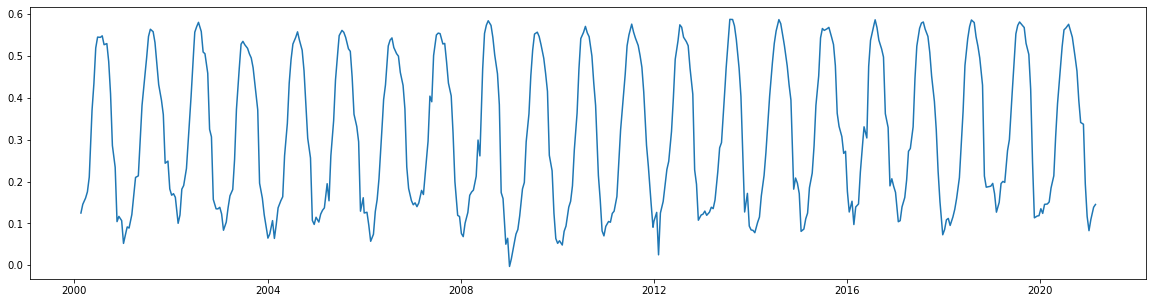

In [34]:
import matplotlib.pyplot as plt

fig,ax= plt.subplots(figsize=(20,5))
ax.plot(df['time'],df['_250m_16_days_NDVI'])

In [35]:
df.to_csv('dora.csv') # meglio specificare to_csv(NOMEFILE, index=False) altrimenti nel csv mette una colonna che viene popolata con il valore dell'indice

In [38]:
df.rename(columns={'_250m_16_days_NDVI': 'NDVI_dora'},inplace=True) 

In [36]:
df['Year'] = df['time'].dt.year
df['Week'] = df['time'].dt.week


<ipython-input-36-df9c29fb1ce3>:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['Week'] = df['time'].dt.week


,time,NDVI_dora,Year,Week
0,2000-02-20,0.124917,2000,7
1,2000-02-27,0.135323,2000,8
2,2000-03-05,0.145729,2000,9
3,2000-03-12,0.150668,2000,10
4,2000-03-19,0.155607,2000,11
...,...,...,...,...
1092,2021-01-24,0.119041,2021,3
1093,2021-01-31,0.128868,2021,4
1094,2021-02-07,0.138695,2021,5
1095,2021-02-14,0.142033,2021,6


In [43]:
mediapluriennale = df.groupby('Week').apply(lambda x: x.NDVI_dora.mean()).reset_index()
mediapluriennale.rename(columns={0:'media'},inplace=True)
df['anomalia_dora'] = df.apply(lambda row: row['NDVI_dora'] - mediapluriennale['media'].loc[mediapluriennale['Week'] == row['Week']].iloc[0], axis=1)

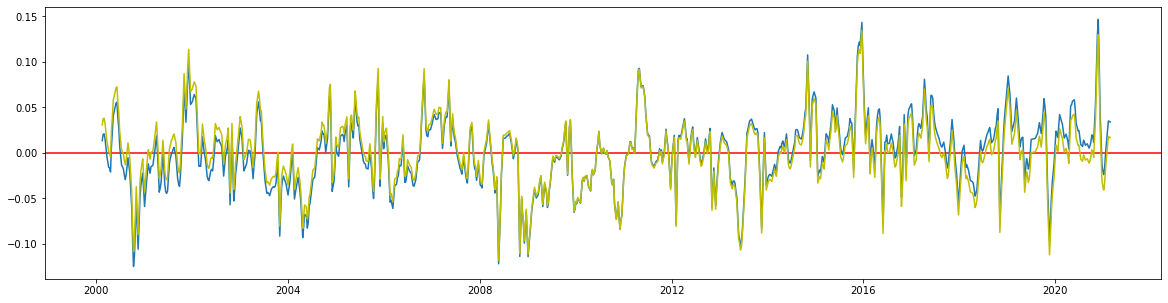

In [52]:
import matplotlib.pyplot as plt

fig,ax= plt.subplots(figsize=(20,5))
ax.axhline(y=0,color='r')
ax.plot(df['time'],df['anomalia_dora'])
ax.plot(df['time'],detrend(df['anomalia_dora']), color='y')

In [48]:
df.to_csv('dora.csv')